In [29]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from tqdm import tqdm
import shutil
import pandas as pd
from sklearn.cluster import KMeans
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import multiprocessing

np.random.seed(42)
random.seed(42)

In [31]:
def locate_bands_in_masks(mask_dir, raw_dir, output_dir=None, output_method='center'):
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    results = {}
    mask_files = [f for f in os.listdir(mask_dir) if f.startswith('Mask_') and f.endswith('.tif')]
    
    for mask_file in tqdm(sorted(mask_files), desc="Processing masks"):
        mask_number = mask_file.split('_')[1].split('.')[0]
        raw_file = f"Gel_{mask_number}.tif"
        
        mask_path = os.path.join(mask_dir, mask_file)
        raw_path = os.path.join(raw_dir, raw_file)
        
        if not os.path.exists(raw_path):
            print(f"Warning: Raw file {raw_file} not found. Skipping.")
            continue
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
        
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
        
        bands = []
        for i in range(1, num_labels):
            x, y = centroids[i]
            
            if output_method == 'center':
                bands.append((int(x), int(y)))
            elif output_method == 'topleft':
                left = stats[i, cv2.CC_STAT_LEFT]
                top = stats[i, cv2.CC_STAT_TOP]
                bands.append((left, top))
            elif output_method == 'bottomleft':
                left = stats[i, cv2.CC_STAT_LEFT]
                top = stats[i, cv2.CC_STAT_TOP]
                height = stats[i, cv2.CC_STAT_HEIGHT]
                bands.append((left, top + height - 1))
        
        bands = sorted(bands, key=lambda pos: pos[1])
        results[mask_file] = bands
        
        if output_dir:
            raw_img = cv2.imread(raw_path)
            raw_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
            
            for i, (x, y) in enumerate(bands):
                cv2.circle(raw_rgb, (x, y), 5, (255, 0, 0), -1)
                cv2.putText(raw_rgb, f"Band {i+1}", (x + 10, y), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            plt.figure(figsize=(10, 8))
            plt.imshow(raw_rgb)
            plt.title(f"Detected Bands in {raw_file}")
            plt.axis('on')
            plt.savefig(os.path.join(output_dir, f"detected_bands_{mask_number}.png"), dpi=300)
            plt.close()
        
        print(f"File: {mask_file} -> {raw_file}")
        for i, band in enumerate(bands):
            print(f"  Band {i+1}: {band}")
    
    return results

In [33]:
def process_image(gel_file, raw_dir, mask_dir, window_size=50, stride=25):
    gel_number = gel_file.split('_')[1].split('.')[0]
    mask_file = f"Mask_{gel_number}.tif"
    
    gel_path = os.path.join(raw_dir, gel_file)
    mask_path = os.path.join(mask_dir, mask_file)
    
    if not os.path.exists(mask_path):
        return None, None, None, None
    
    img = cv2.imread(gel_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape[:2]
    
    windows = []
    positions = []
    
    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            window = img[y:y+window_size, x:x+window_size]
            if window.shape == (window_size, window_size):
                windows.append(window)
                positions.append((x, y))
    
    return windows, positions, [gel_file] * len(windows), [gel_number] * len(windows)

In [35]:
def prepare_training_data(raw_dir, mask_dir, output_dir, window_size=50, stride=25, 
                         dim_reduction='pca', n_components=2, max_workers=4):
    os.makedirs(os.path.join(output_dir, 'positive'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'background'), exist_ok=True)
    
    gel_files = [f for f in os.listdir(raw_dir) if f.startswith('Gel_') and f.endswith('.tif')]
    
    all_windows = []
    all_positions = []
    all_filenames = []
    all_gel_numbers = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {
            executor.submit(process_image, gel_file, raw_dir, mask_dir, window_size, stride): gel_file
            for gel_file in gel_files
        }
        
        for future in tqdm(as_completed(future_to_file), total=len(gel_files), desc="Processing images"):
            windows, positions, filenames, gel_numbers = future.result()
            if windows is not None:
                all_windows.extend(windows)
                all_positions.extend(positions)
                all_filenames.extend(filenames)
                all_gel_numbers.extend(gel_numbers)
    
    if not all_windows:
        print("Error: No windows were created. Check input directories and files.")
        return
    
    all_windows = np.array(all_windows)
    all_positions = np.array(all_positions)
    
    print(f"Created {len(all_windows)} windows from {len(gel_files)} images")
    
    print("Extracting features and reducing dimensions...")
    features = all_windows.reshape(all_windows.shape[0], -1) / 255.0
    
    reducer = PCA(n_components=n_components)
    reduced_features = reducer.fit_transform(features)
    
    print("Clustering windows...")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced_features)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_features[labels==0, 0], reduced_features[labels==0, 1], c='r', label='Cluster 0')
    plt.scatter(reduced_features[labels==1, 0], reduced_features[labels==1, 1], c='b', label='Cluster 1')
    plt.legend()
    plt.title("Window Clusters")
    plt.savefig(os.path.join(output_dir, "clusters.png"), dpi=300)
    plt.close()
    
    for cluster_id in [0, 1]:
        indices = np.where(labels == cluster_id)[0]
        if len(indices) > 0:
            sample_indices = indices[:min(10, len(indices))]
            
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            axes = axes.flatten()
            
            for j, idx in enumerate(sample_indices):
                if j < len(axes):
                    axes[j].imshow(all_windows[idx], cmap='gray')
                    axes[j].set_title(f"Cluster {cluster_id}")
                    axes[j].axis('off')
            
            for j in range(len(sample_indices), len(axes)):
                axes[j].axis('off')
                
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"cluster_{cluster_id}_samples.png"), dpi=300)
            plt.close()
    
    cluster_sizes = [np.sum(labels == i) for i in range(2)]
    positive_cluster = np.argmin(cluster_sizes)
    
    print(f"Assigned cluster {positive_cluster} as positive (bands)")
    print(f"  Positive samples: {cluster_sizes[positive_cluster]}")
    print(f"  Background samples: {cluster_sizes[1-positive_cluster]}")
    
    def save_window(i):
        window, label = all_windows[i], labels[i]
        folder = 'positive' if label == positive_cluster else 'background'
        x, y = all_positions[i]
        filename = all_filenames[i].split('.')[0]
        
        output_path = os.path.join(output_dir, folder, f"{filename}_x{x}_y{y}.tif")
        cv2.imwrite(output_path, window)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(save_window, range(len(all_windows))), 
                 total=len(all_windows), desc="Saving windows"))
    
    metadata = {
        'window_index': list(range(len(all_windows))),
        'filename': all_filenames,
        'gel_number': all_gel_numbers,
        'position_x': all_positions[:, 0],
        'position_y': all_positions[:, 1],
        'cluster': labels,
        'is_positive': labels == positive_cluster
    }
    
    df = pd.DataFrame(metadata)
    df.to_csv(os.path.join(output_dir, "window_metadata.csv"), index=False)
    
    print(f"Training data preparation completed. Results saved to {output_dir}")
    return df

In [37]:
def create_augmentation_folders(base_path):
    augmentation_types = ['rotations', 'gaussian_noise', 'stretch_wrap', 
                         'brightness', 'deletions', 'training']
    
    for aug_type in augmentation_types:
        os.makedirs(os.path.join(base_path, aug_type), exist_ok=True)
    
    return os.path.join(base_path, 'training')

def apply_augmentation(file_info, augmentations, positive_dir, output_dir, training_output):
    file, folder = file_info
    img_path = os.path.join(positive_dir if folder == 'positive' else 
                           os.path.join(os.path.dirname(positive_dir), 'background'), file)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return
    
    for aug_name, aug_func in augmentations.items():
        aug_img = aug_func(img)
        
        aug_dir = os.path.join(output_dir, aug_name)
        aug_path = os.path.join(aug_dir, f"{file.split('.')[0]}_{aug_name}.tif")
        cv2.imwrite(aug_path, aug_img)
        
        train_path = os.path.join(training_output, f"{file.split('.')[0]}_{aug_name}.tif")
        shutil.copy(aug_path, train_path)

def augment_training_data(training_dir, output_dir, augment_positive_only=True, max_workers=4):
    training_output = os.path.join(output_dir, 'training')
    
    augmentation_types = ['rotations', 'gaussian_noise', 'stretch_wrap', 
                         'brightness', 'deletions', 'training']
    
    for aug_type in augmentation_types:
        os.makedirs(os.path.join(output_dir, aug_type), exist_ok=True)
    
    def rotation_augment(img, degrees=5):
        angle = random.choice([-degrees, degrees])
        height, width = img.shape[:2]
        center = (width // 2, height // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, rotation_matrix, (width, height))
    
    def noise_augment(img, var=0.01):
        img_float = img.astype(np.float32)
        noise = np.random.normal(0, var * 255, img.shape).astype(np.float32)
        noisy_img = img_float + noise
        return np.clip(noisy_img, 0, 255).astype(np.uint8)
    
    def stretch_augment(img, factor=0.1):
        h, w = img.shape[:2]
        pts1 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        offset = int(w * factor)
        bottom_offset = random.randint(-offset, offset)
        pts2 = np.float32([
            [0, 0], 
            [w, 0], 
            [0 + bottom_offset, h], 
            [w + bottom_offset, h]
        ])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(img, M, (w, h))
    
    def brightness_augment(img, factor=0.2):
        adjustment = 1.0 + random.uniform(-factor, factor)
        return cv2.convertScaleAbs(img, alpha=adjustment)
    
    def deletion_augment(img, max_size=0.1):
        h, w = img.shape[:2]
        del_w = int(w * random.uniform(0.05, max_size))
        del_h = int(h * random.uniform(0.05, max_size))
        x = random.randint(0, w - del_w)
        y = random.randint(0, h - del_h)
        deleted = img.copy()
        
        bg_value = np.median(img[0:10, 0:10])
        deleted[y:y+del_h, x:x+del_w] = bg_value
        
        return deleted
    
    augmentations = {
        'rotations': rotation_augment,
        'gaussian_noise': noise_augment,
        'stretch_wrap': stretch_augment,
        'brightness': brightness_augment,
        'deletions': deletion_augment
    }
    
    files_to_process = []
    
    positive_dir = os.path.join(training_dir, 'positive')
    if os.path.exists(positive_dir):
        pos_files = [f for f in os.listdir(positive_dir) if f.endswith('.tif')]
        files_to_process.extend([(f, 'positive') for f in pos_files])
    
    if not augment_positive_only:
        background_dir = os.path.join(training_dir, 'background')
        if os.path.exists(background_dir):
            bg_files = [f for f in os.listdir(background_dir) if f.endswith('.tif')]
            
            sample_size = min(len(bg_files), 100)
            sampled_files = random.sample(bg_files, sample_size)
            files_to_process.extend([(f, 'background') for f in sampled_files])
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(
            executor.map(lambda file_info: apply_augmentation(
                file_info, augmentations, positive_dir, output_dir, training_output), 
                files_to_process),
            total=len(files_to_process),
            desc="Applying augmentations"
        ))
    
    for folder in ['positive', 'background']:
        src_dir = os.path.join(training_dir, folder)
        if os.path.exists(src_dir):
            for file in os.listdir(src_dir):
                if file.endswith('.tif'):
                    src_path = os.path.join(src_dir, file)
                    dst_path = os.path.join(training_output, file)
                    shutil.copy(src_path, dst_path)
    
    print(f"Augmentation completed. Results saved to {output_dir}")
    return training_output

In [39]:
mask_dir = r"/Users/linn/Desktop/STT811-Project/Lab Gels/mask"
raw_dir = r"/Users/linn/Desktop/STT811-Project/Lab Gels/raw"
output_dir = r"/Users/linn/Desktop/STT811-Project/Lab Gels/results"
training_dir = os.path.join(output_dir, 'training_data')
augmented_dir = os.path.join(output_dir, 'augmented_data')

os.makedirs(output_dir, exist_ok=True)

In [41]:
#Locating Bands in Mask Images
step1_start = time.time()
results = locate_bands_in_masks(mask_dir, raw_dir, output_dir)

data = []
for filename, bands in results.items():
    for i, (x, y) in enumerate(bands):
        data.append({
            'filename': filename,
            'band_number': i + 1,
            'x': x,
            'y': y
        })

df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, "band_locations.csv")
df.to_csv(csv_path, index=False)

step1_time = time.time() - step1_start
print(f"Step 1 completed in {step1_time:.2f} seconds")
print(f"Band locations saved to {csv_path}")


=== Step 1: Locating Bands in Mask Images ===


Processing masks:   5%|█▎                        | 1/20 [00:00<00:10,  1.84it/s]

File: Mask_1.tif -> Gel_1.tif
  Band 1: (614, 377)
  Band 2: (88, 384)
  Band 3: (613, 390)
  Band 4: (88, 399)
  Band 5: (614, 406)
  Band 6: (88, 414)
  Band 7: (613, 424)
  Band 8: (89, 429)
  Band 9: (614, 442)
  Band 10: (88, 447)
  Band 11: (615, 465)
  Band 12: (90, 471)
  Band 13: (614, 489)
  Band 14: (91, 497)
  Band 15: (615, 521)
  Band 16: (466, 523)
  Band 17: (90, 527)
  Band 18: (916, 554)
  Band 19: (616, 559)
  Band 20: (840, 559)
  Band 21: (690, 563)
  Band 22: (763, 563)
  Band 23: (94, 564)
  Band 24: (616, 604)
  Band 25: (95, 609)
  Band 26: (553, 1225)
  Band 27: (94, 1233)
  Band 28: (552, 1239)
  Band 29: (95, 1247)
  Band 30: (552, 1253)
  Band 31: (94, 1262)
  Band 32: (782, 1266)
  Band 33: (551, 1269)
  Band 34: (93, 1276)
  Band 35: (552, 1287)
  Band 36: (94, 1295)
  Band 37: (552, 1307)
  Band 38: (96, 1316)
  Band 39: (552, 1330)
  Band 40: (95, 1338)
  Band 41: (552, 1360)
  Band 42: (860, 1362)
  Band 43: (707, 1364)
  Band 44: (630, 1366)
  Band 45

Processing masks:  10%|██▌                       | 2/20 [00:01<00:10,  1.74it/s]

File: Mask_10.tif -> Gel_10.tif
  Band 1: (81, 249)
  Band 2: (80, 258)
  Band 3: (80, 268)
  Band 4: (81, 279)
  Band 5: (80, 293)
  Band 6: (1141, 308)
  Band 7: (1216, 308)
  Band 8: (689, 308)
  Band 9: (80, 309)
  Band 10: (1291, 310)
  Band 11: (312, 318)
  Band 12: (81, 329)
  Band 13: (82, 353)
  Band 14: (82, 383)
  Band 15: (83, 423)
  Band 16: (79, 1118)
  Band 17: (80, 1126)
  Band 18: (79, 1136)
  Band 19: (80, 1146)
  Band 20: (80, 1159)
  Band 21: (79, 1174)
  Band 22: (1300, 1180)
  Band 23: (996, 1181)
  Band 24: (1072, 1182)
  Band 25: (1149, 1182)
  Band 26: (1223, 1182)
  Band 27: (768, 1183)
  Band 28: (845, 1184)
  Band 29: (537, 1185)
  Band 30: (461, 1188)
  Band 31: (385, 1189)
  Band 32: (309, 1191)
  Band 33: (79, 1192)
  Band 34: (232, 1194)
  Band 35: (80, 1216)
  Band 36: (80, 1244)
  Band 37: (82, 1281)


Processing masks:  15%|███▉                      | 3/20 [00:01<00:09,  1.75it/s]

File: Mask_11.tif -> Gel_11.tif
  Band 1: (76, 261)
  Band 2: (77, 269)
  Band 3: (77, 279)
  Band 4: (77, 290)
  Band 5: (78, 303)
  Band 6: (985, 319)
  Band 7: (78, 319)
  Band 8: (910, 320)
  Band 9: (1061, 321)
  Band 10: (1212, 322)
  Band 11: (683, 323)
  Band 12: (1287, 323)
  Band 13: (533, 325)
  Band 14: (381, 327)
  Band 15: (1439, 329)
  Band 16: (230, 333)
  Band 17: (77, 337)
  Band 18: (1516, 338)
  Band 19: (155, 339)
  Band 20: (77, 363)
  Band 21: (78, 395)
  Band 22: (80, 436)
  Band 23: (75, 1122)
  Band 24: (76, 1129)
  Band 25: (76, 1138)
  Band 26: (76, 1148)
  Band 27: (76, 1161)
  Band 28: (76, 1176)
  Band 29: (1522, 1188)
  Band 30: (839, 1191)
  Band 31: (1147, 1191)
  Band 32: (687, 1192)
  Band 33: (763, 1192)
  Band 34: (1223, 1192)
  Band 35: (1299, 1193)
  Band 36: (77, 1194)
  Band 37: (457, 1196)
  Band 38: (533, 1197)
  Band 39: (304, 1199)
  Band 40: (227, 1202)
  Band 41: (151, 1203)
  Band 42: (76, 1217)
  Band 43: (76, 1245)
  Band 44: (76, 1283

Processing masks:  20%|█████▏                    | 4/20 [00:02<00:09,  1.72it/s]

File: Mask_12.tif -> Gel_12.tif
  Band 1: (69, 257)
  Band 2: (69, 267)
  Band 3: (69, 278)
  Band 4: (70, 289)
  Band 5: (69, 303)
  Band 6: (70, 318)
  Band 7: (526, 319)
  Band 8: (69, 337)
  Band 9: (69, 360)
  Band 10: (70, 389)
  Band 11: (71, 424)
  Band 12: (65, 1120)
  Band 13: (65, 1129)
  Band 14: (65, 1139)
  Band 15: (65, 1149)
  Band 16: (65, 1160)
  Band 17: (65, 1174)
  Band 18: (983, 1186)
  Band 19: (1058, 1186)
  Band 20: (1439, 1186)
  Band 21: (676, 1187)
  Band 22: (753, 1187)
  Band 23: (521, 1189)
  Band 24: (444, 1190)
  Band 25: (65, 1191)
  Band 26: (368, 1192)
  Band 27: (293, 1193)
  Band 28: (64, 1211)
  Band 29: (64, 1238)
  Band 30: (65, 1270)


Processing masks:  25%|██████▌                   | 5/20 [00:02<00:08,  1.81it/s]

File: Mask_13.tif -> Gel_13.tif
  Band 1: (73, 258)
  Band 2: (73, 267)
  Band 3: (74, 278)
  Band 4: (74, 288)
  Band 5: (74, 301)
  Band 6: (1131, 302)
  Band 7: (1056, 303)
  Band 8: (1205, 303)
  Band 9: (1281, 303)
  Band 10: (604, 303)
  Band 11: (528, 304)
  Band 12: (907, 305)
  Band 13: (982, 305)
  Band 14: (755, 305)
  Band 15: (453, 306)
  Band 16: (832, 306)
  Band 17: (680, 306)
  Band 18: (150, 314)
  Band 19: (74, 317)
  Band 20: (75, 336)
  Band 21: (75, 359)
  Band 22: (76, 387)
  Band 23: (77, 423)
  Band 24: (674, 1119)
  Band 25: (68, 1121)
  Band 26: (675, 1126)
  Band 27: (68, 1129)
  Band 28: (674, 1134)
  Band 29: (68, 1136)
  Band 30: (674, 1145)
  Band 31: (68, 1145)
  Band 32: (69, 1155)
  Band 33: (674, 1158)
  Band 34: (68, 1168)
  Band 35: (522, 1170)
  Band 36: (674, 1173)
  Band 37: (370, 1182)
  Band 38: (68, 1184)
  Band 39: (217, 1185)
  Band 40: (294, 1185)
  Band 41: (142, 1190)
  Band 42: (674, 1190)
  Band 43: (68, 1202)
  Band 44: (673, 1213)
  

Processing masks:  30%|███████▊                  | 6/20 [00:03<00:07,  1.76it/s]

File: Mask_14.tif -> Gel_14.tif
  Band 1: (78, 265)
  Band 2: (77, 275)
  Band 3: (79, 286)
  Band 4: (78, 299)
  Band 5: (912, 311)
  Band 6: (838, 312)
  Band 7: (1061, 313)
  Band 8: (78, 313)
  Band 9: (762, 314)
  Band 10: (533, 315)
  Band 11: (1437, 315)
  Band 12: (458, 316)
  Band 13: (685, 316)
  Band 14: (986, 316)
  Band 15: (1136, 316)
  Band 16: (610, 317)
  Band 17: (1211, 317)
  Band 18: (1362, 317)
  Band 19: (1286, 318)
  Band 20: (79, 331)
  Band 21: (79, 350)
  Band 22: (78, 378)
  Band 23: (79, 412)
  Band 24: (81, 455)
  Band 25: (72, 1130)
  Band 26: (72, 1140)
  Band 27: (72, 1151)
  Band 28: (72, 1162)
  Band 29: (73, 1176)
  Band 30: (832, 1179)
  Band 31: (909, 1179)
  Band 32: (755, 1180)
  Band 33: (1064, 1182)
  Band 34: (1142, 1184)
  Band 35: (1218, 1184)
  Band 36: (1371, 1186)
  Band 37: (604, 1187)
  Band 38: (451, 1189)
  Band 39: (375, 1190)
  Band 40: (300, 1191)
  Band 41: (74, 1192)
  Band 42: (148, 1194)
  Band 43: (223, 1195)
  Band 44: (73, 12

Processing masks:  35%|█████████                 | 7/20 [00:03<00:06,  1.88it/s]

File: Mask_15.tif -> Gel_15.tif
  Band 1: (75, 290)
  Band 2: (75, 302)
  Band 3: (75, 315)
  Band 4: (76, 329)
  Band 5: (77, 345)
  Band 6: (758, 350)
  Band 7: (834, 352)
  Band 8: (380, 353)
  Band 9: (533, 353)
  Band 10: (306, 355)
  Band 11: (456, 355)
  Band 12: (608, 355)
  Band 13: (683, 355)
  Band 14: (910, 355)
  Band 15: (231, 356)
  Band 16: (77, 364)
  Band 17: (154, 365)
  Band 18: (77, 386)
  Band 19: (78, 413)
  Band 20: (79, 446)
  Band 21: (80, 485)
  Band 22: (78, 1156)
  Band 23: (78, 1167)
  Band 24: (78, 1180)
  Band 25: (78, 1193)
  Band 26: (78, 1208)
  Band 27: (766, 1215)
  Band 28: (536, 1219)
  Band 29: (614, 1219)
  Band 30: (382, 1221)
  Band 31: (78, 1225)
  Band 32: (229, 1226)
  Band 33: (153, 1230)
  Band 34: (78, 1247)
  Band 35: (77, 1274)
  Band 36: (78, 1305)
  Band 37: (76, 1344)


Processing masks:  40%|██████████▍               | 8/20 [00:04<00:06,  1.80it/s]

File: Mask_16.tif -> Gel_16.tif
  Band 1: (87, 299)
  Band 2: (87, 310)
  Band 3: (87, 321)
  Band 4: (88, 334)
  Band 5: (89, 349)
  Band 6: (615, 367)
  Band 7: (90, 367)
  Band 8: (993, 370)
  Band 9: (918, 371)
  Band 10: (390, 371)
  Band 11: (842, 372)
  Band 12: (766, 373)
  Band 13: (316, 376)
  Band 14: (89, 387)
  Band 15: (90, 415)
  Band 16: (93, 448)
  Band 17: (93, 491)
  Band 18: (165, 1153)
  Band 19: (165, 1164)
  Band 20: (166, 1175)
  Band 21: (1004, 1179)
  Band 22: (852, 1181)
  Band 23: (165, 1187)
  Band 24: (700, 1188)
  Band 25: (623, 1189)
  Band 26: (547, 1190)
  Band 27: (470, 1193)
  Band 28: (393, 1196)
  Band 29: (318, 1197)
  Band 30: (166, 1200)
  Band 31: (241, 1201)
  Band 32: (1081, 1213)
  Band 33: (166, 1217)
  Band 34: (394, 1223)
  Band 35: (242, 1227)
  Band 36: (166, 1234)
  Band 37: (167, 1259)
  Band 38: (167, 1290)
  Band 39: (167, 1330)


Processing masks:  45%|███████████▋              | 9/20 [00:04<00:05,  1.83it/s]

File: Mask_17.tif -> Gel_17.tif
  Band 1: (71, 292)
  Band 2: (71, 303)
  Band 3: (71, 316)
  Band 4: (71, 329)
  Band 5: (72, 343)
  Band 6: (73, 362)
  Band 7: (226, 372)
  Band 8: (377, 372)
  Band 9: (677, 373)
  Band 10: (1127, 375)
  Band 11: (152, 377)
  Band 12: (72, 382)
  Band 13: (73, 410)
  Band 14: (72, 444)
  Band 15: (74, 488)
  Band 16: (62, 1146)
  Band 17: (63, 1156)
  Band 18: (63, 1167)
  Band 19: (63, 1179)
  Band 20: (62, 1193)
  Band 21: (63, 1210)
  Band 22: (62, 1231)
  Band 23: (62, 1256)
  Band 24: (62, 1289)
  Band 25: (369, 1327)
  Band 26: (139, 1327)
  Band 27: (214, 1327)
  Band 28: (291, 1327)
  Band 29: (445, 1328)
  Band 30: (61, 1329)
  Band 31: (522, 1330)
  Band 32: (597, 1333)
  Band 33: (673, 1334)
  Band 34: (749, 1337)
  Band 35: (826, 1339)
  Band 36: (1132, 1340)
  Band 37: (1056, 1341)


Processing masks:  50%|████████████▌            | 10/20 [00:05<00:05,  1.94it/s]

File: Mask_18.tif -> Gel_18.tif
  Band 1: (844, 253)
  Band 2: (844, 262)
  Band 3: (90, 264)
  Band 4: (844, 270)
  Band 5: (90, 275)
  Band 6: (844, 282)
  Band 7: (91, 286)
  Band 8: (844, 294)
  Band 9: (90, 297)
  Band 10: (90, 309)
  Band 11: (844, 311)
  Band 12: (995, 320)
  Band 13: (1297, 321)
  Band 14: (919, 325)
  Band 15: (90, 326)
  Band 16: (844, 329)
  Band 17: (90, 344)
  Band 18: (844, 354)
  Band 19: (91, 370)
  Band 20: (846, 386)
  Band 21: (92, 400)
  Band 22: (541, 412)
  Band 23: (768, 412)
  Band 24: (318, 413)
  Band 25: (391, 413)
  Band 26: (466, 413)
  Band 27: (617, 414)
  Band 28: (243, 418)
  Band 29: (170, 419)
  Band 30: (846, 427)
  Band 31: (93, 442)
  Band 32: (74, 1126)
  Band 33: (74, 1139)
  Band 34: (74, 1149)
  Band 35: (73, 1161)
  Band 36: (73, 1173)
  Band 37: (73, 1187)
  Band 38: (612, 1192)
  Band 39: (457, 1193)
  Band 40: (767, 1194)
  Band 41: (378, 1197)
  Band 42: (73, 1204)
  Band 43: (74, 1227)
  Band 44: (74, 1257)
  Band 45: (73

Processing masks:  55%|█████████████▊           | 11/20 [00:05<00:04,  1.95it/s]

File: Mask_19.tif -> Gel_19.tif
  Band 1: (79, 260)
  Band 2: (78, 271)
  Band 3: (78, 282)
  Band 4: (78, 294)
  Band 5: (78, 309)
  Band 6: (78, 327)
  Band 7: (1138, 339)
  Band 8: (1062, 340)
  Band 9: (531, 341)
  Band 10: (683, 342)
  Band 11: (835, 342)
  Band 12: (911, 342)
  Band 13: (1213, 342)
  Band 14: (607, 343)
  Band 15: (1288, 344)
  Band 16: (758, 345)
  Band 17: (78, 347)
  Band 18: (231, 350)
  Band 19: (78, 374)
  Band 20: (78, 407)
  Band 21: (78, 451)
  Band 22: (374, 1213)
  Band 23: (450, 1213)
  Band 24: (680, 1213)
  Band 25: (297, 1215)
  Band 26: (146, 1217)
  Band 27: (221, 1217)


Processing masks:  60%|███████████████          | 12/20 [00:06<00:04,  1.91it/s]

File: Mask_2.tif -> Gel_2.tif
  Band 1: (88, 314)
  Band 2: (88, 325)
  Band 3: (89, 335)
  Band 4: (89, 347)
  Band 5: (90, 360)
  Band 6: (614, 374)
  Band 7: (688, 374)
  Band 8: (985, 374)
  Band 9: (763, 375)
  Band 10: (539, 375)
  Band 11: (390, 376)
  Band 12: (317, 377)
  Band 13: (90, 378)
  Band 14: (839, 378)
  Band 15: (464, 379)
  Band 16: (538, 382)
  Band 17: (613, 382)
  Band 18: (762, 383)
  Band 19: (986, 383)
  Band 20: (165, 384)
  Band 21: (687, 384)
  Band 22: (838, 384)
  Band 23: (390, 385)
  Band 24: (239, 386)
  Band 25: (316, 386)
  Band 26: (166, 394)
  Band 27: (90, 397)
  Band 28: (612, 412)
  Band 29: (538, 414)
  Band 30: (687, 414)
  Band 31: (463, 415)
  Band 32: (763, 415)
  Band 33: (987, 415)
  Band 34: (389, 415)
  Band 35: (316, 418)
  Band 36: (837, 420)
  Band 37: (241, 421)
  Band 38: (90, 422)
  Band 39: (167, 426)
  Band 40: (612, 431)
  Band 41: (687, 431)
  Band 42: (463, 431)
  Band 43: (538, 431)
  Band 44: (762, 433)
  Band 45: (390, 43

Processing masks:  65%|████████████████▎        | 13/20 [00:06<00:03,  1.99it/s]

File: Mask_20.tif -> Gel_20.tif
  Band 1: (93, 273)
  Band 2: (94, 284)
  Band 3: (1301, 291)
  Band 4: (1001, 293)
  Band 5: (1227, 293)
  Band 6: (927, 294)
  Band 7: (1077, 294)
  Band 8: (1152, 294)
  Band 9: (851, 295)
  Band 10: (93, 295)
  Band 11: (623, 298)
  Band 12: (775, 298)
  Band 13: (699, 299)
  Band 14: (546, 301)
  Band 15: (471, 302)
  Band 16: (395, 307)
  Band 17: (94, 307)
  Band 18: (321, 312)
  Band 19: (245, 316)
  Band 20: (1002, 320)
  Band 21: (171, 321)
  Band 22: (927, 321)
  Band 23: (95, 322)
  Band 24: (852, 323)
  Band 25: (776, 325)
  Band 26: (623, 326)
  Band 27: (698, 326)
  Band 28: (547, 328)
  Band 29: (96, 339)
  Band 30: (96, 360)
  Band 31: (97, 386)
  Band 32: (98, 420)
  Band 33: (100, 462)
  Band 34: (91, 1142)
  Band 35: (91, 1152)
  Band 36: (91, 1163)
  Band 37: (698, 1171)
  Band 38: (92, 1174)
  Band 39: (471, 1179)
  Band 40: (395, 1183)
  Band 41: (319, 1185)
  Band 42: (92, 1187)
  Band 43: (241, 1188)
  Band 44: (166, 1192)
  Band

Processing masks:  70%|█████████████████▌       | 14/20 [00:07<00:03,  1.91it/s]

File: Mask_3.tif -> Gel_3.tif
  Band 1: (86, 308)
  Band 2: (86, 319)
  Band 3: (86, 331)
  Band 4: (86, 343)
  Band 5: (87, 357)
  Band 6: (88, 374)
  Band 7: (88, 393)
  Band 8: (89, 418)
  Band 9: (1070, 428)
  Band 10: (994, 429)
  Band 11: (1295, 430)
  Band 12: (844, 432)
  Band 13: (1370, 432)
  Band 14: (693, 433)
  Band 15: (1445, 435)
  Band 16: (1523, 435)
  Band 17: (469, 436)
  Band 18: (393, 439)
  Band 19: (318, 440)
  Band 20: (244, 443)
  Band 21: (91, 448)
  Band 22: (92, 482)
  Band 23: (94, 1176)
  Band 24: (94, 1188)
  Band 25: (93, 1199)
  Band 26: (94, 1211)
  Band 27: (94, 1226)
  Band 28: (94, 1241)
  Band 29: (95, 1260)
  Band 30: (94, 1284)
  Band 31: (632, 1310)
  Band 32: (709, 1310)
  Band 33: (477, 1311)
  Band 34: (785, 1311)
  Band 35: (322, 1312)
  Band 36: (399, 1312)
  Band 37: (554, 1312)
  Band 38: (1013, 1312)
  Band 39: (95, 1315)
  Band 40: (170, 1316)
  Band 41: (245, 1316)
  Band 42: (96, 1352)


Processing masks:  75%|██████████████████▊      | 15/20 [00:08<00:02,  1.83it/s]

File: Mask_4.tif -> Gel_4.tif
  Band 1: (89, 324)
  Band 2: (89, 335)
  Band 3: (89, 348)
  Band 4: (89, 361)
  Band 5: (89, 377)
  Band 6: (90, 397)
  Band 7: (90, 418)
  Band 8: (840, 431)
  Band 9: (540, 435)
  Band 10: (614, 435)
  Band 11: (690, 435)
  Band 12: (390, 437)
  Band 13: (464, 437)
  Band 14: (317, 440)
  Band 15: (241, 445)
  Band 16: (90, 447)
  Band 17: (166, 449)
  Band 18: (91, 483)
  Band 19: (92, 530)
  Band 20: (81, 1181)
  Band 21: (695, 1183)
  Band 22: (542, 1186)
  Band 23: (233, 1190)
  Band 24: (80, 1192)
  Band 25: (81, 1203)
  Band 26: (81, 1217)
  Band 27: (81, 1231)
  Band 28: (849, 1241)
  Band 29: (619, 1244)
  Band 30: (464, 1246)
  Band 31: (388, 1248)
  Band 32: (81, 1248)
  Band 33: (310, 1250)
  Band 34: (156, 1255)
  Band 35: (81, 1269)
  Band 36: (81, 1295)
  Band 37: (82, 1329)
  Band 38: (80, 1371)


Processing masks:  80%|████████████████████     | 16/20 [00:08<00:02,  1.93it/s]

File: Mask_5.tif -> Gel_5.tif
  Band 1: (922, 265)
  Band 2: (997, 271)
  Band 3: (1073, 271)
  Band 4: (922, 273)
  Band 5: (90, 278)
  Band 6: (922, 280)
  Band 7: (922, 288)
  Band 8: (89, 290)
  Band 9: (922, 297)
  Band 10: (90, 300)
  Band 11: (921, 307)
  Band 12: (89, 310)
  Band 13: (921, 322)
  Band 14: (90, 323)
  Band 15: (1148, 328)
  Band 16: (1224, 330)
  Band 17: (1299, 333)
  Band 18: (89, 336)
  Band 19: (921, 337)
  Band 20: (1451, 342)
  Band 21: (89, 353)
  Band 22: (922, 359)
  Band 23: (467, 365)
  Band 24: (617, 366)
  Band 25: (393, 367)
  Band 26: (318, 370)
  Band 27: (242, 374)
  Band 28: (90, 375)
  Band 29: (166, 378)
  Band 30: (922, 386)
  Band 31: (90, 405)
  Band 32: (920, 421)
  Band 33: (89, 439)
  Band 34: (70, 1145)
  Band 35: (71, 1157)
  Band 36: (71, 1170)
  Band 37: (71, 1185)
  Band 38: (72, 1199)
  Band 39: (71, 1215)
  Band 40: (71, 1236)
  Band 41: (70, 1263)
  Band 42: (530, 1290)
  Band 43: (453, 1292)
  Band 44: (299, 1295)
  Band 45: (2

Processing masks:  85%|█████████████████████▎   | 17/20 [00:09<00:01,  1.89it/s]

File: Mask_6.tif -> Gel_6.tif
  Band 1: (845, 284)
  Band 2: (996, 290)
  Band 3: (1298, 295)
  Band 4: (845, 295)
  Band 5: (88, 303)
  Band 6: (844, 304)
  Band 7: (88, 313)
  Band 8: (844, 316)
  Band 9: (88, 323)
  Band 10: (844, 330)
  Band 11: (88, 334)
  Band 12: (1223, 345)
  Band 13: (1071, 346)
  Band 14: (1147, 346)
  Band 15: (844, 347)
  Band 16: (88, 348)
  Band 17: (920, 350)
  Band 18: (1450, 358)
  Band 19: (88, 365)
  Band 20: (844, 366)
  Band 21: (88, 385)
  Band 22: (844, 392)
  Band 23: (466, 393)
  Band 24: (318, 397)
  Band 25: (542, 397)
  Band 26: (693, 397)
  Band 27: (242, 403)
  Band 28: (88, 410)
  Band 29: (843, 423)
  Band 30: (88, 443)
  Band 31: (844, 463)
  Band 32: (88, 483)
  Band 33: (87, 1163)
  Band 34: (87, 1173)
  Band 35: (87, 1182)
  Band 36: (88, 1193)
  Band 37: (87, 1206)
  Band 38: (87, 1222)
  Band 39: (86, 1239)
  Band 40: (87, 1263)
  Band 41: (87, 1293)
  Band 42: (466, 1325)
  Band 43: (314, 1327)
  Band 44: (238, 1329)
  Band 45: (8

Processing masks:  90%|██████████████████████▌  | 18/20 [00:09<00:01,  1.77it/s]

File: Mask_7.tif -> Gel_7.tif
  Band 1: (75, 282)
  Band 2: (76, 293)
  Band 3: (76, 306)
  Band 4: (76, 319)
  Band 5: (76, 335)
  Band 6: (76, 354)
  Band 7: (679, 358)
  Band 8: (76, 375)
  Band 9: (78, 404)
  Band 10: (78, 440)
  Band 11: (78, 486)
  Band 12: (80, 1140)
  Band 13: (80, 1151)
  Band 14: (80, 1163)
  Band 15: (81, 1175)
  Band 16: (80, 1190)
  Band 17: (80, 1208)
  Band 18: (80, 1229)
  Band 19: (689, 1240)
  Band 20: (156, 1253)
  Band 21: (82, 1255)
  Band 22: (689, 1274)
  Band 23: (614, 1276)
  Band 24: (537, 1277)
  Band 25: (461, 1278)
  Band 26: (385, 1280)
  Band 27: (308, 1283)
  Band 28: (232, 1286)
  Band 29: (82, 1288)
  Band 30: (157, 1289)
  Band 31: (81, 1332)


Processing masks:  95%|███████████████████████▊ | 19/20 [00:10<00:00,  1.89it/s]

File: Mask_8.tif -> Gel_8.tif
  Band 1: (92, 264)
  Band 2: (93, 274)
  Band 3: (93, 285)
  Band 4: (93, 297)
  Band 5: (94, 310)
  Band 6: (94, 327)
  Band 7: (924, 348)
  Band 8: (1000, 348)
  Band 9: (95, 348)
  Band 10: (849, 351)
  Band 11: (1299, 352)
  Band 12: (773, 353)
  Band 13: (472, 355)
  Band 14: (623, 356)
  Band 15: (547, 357)
  Band 16: (397, 359)
  Band 17: (326, 360)
  Band 18: (247, 368)
  Band 19: (171, 374)
  Band 20: (96, 374)
  Band 21: (925, 380)
  Band 22: (1000, 380)
  Band 23: (1075, 381)
  Band 24: (849, 382)
  Band 25: (774, 383)
  Band 26: (698, 386)
  Band 27: (624, 387)
  Band 28: (549, 389)
  Band 29: (96, 409)
  Band 30: (96, 455)


Processing masks: 100%|█████████████████████████| 20/20 [00:10<00:00,  1.89it/s]

File: Mask_9.tif -> Gel_9.tif
  Band 1: (73, 244)
  Band 2: (72, 255)
  Band 3: (73, 266)
  Band 4: (73, 278)
  Band 5: (73, 292)
  Band 6: (73, 310)
  Band 7: (680, 317)
  Band 8: (907, 319)
  Band 9: (983, 319)
  Band 10: (151, 327)
  Band 11: (73, 331)
  Band 12: (74, 358)
  Band 13: (74, 392)
  Band 14: (75, 437)
  Band 15: (73, 1109)
  Band 16: (74, 1119)
  Band 17: (74, 1130)
  Band 18: (74, 1142)
  Band 19: (74, 1155)
  Band 20: (74, 1173)
  Band 21: (989, 1186)
  Band 22: (914, 1188)
  Band 23: (608, 1189)
  Band 24: (684, 1189)
  Band 25: (74, 1193)
  Band 26: (224, 1194)
  Band 27: (301, 1194)
  Band 28: (73, 1220)
  Band 29: (74, 1253)
  Band 30: (74, 1299)
Step 1 completed in 10.61 seconds
Band locations saved to /Users/linn/Desktop/STT811-Project/Lab Gels/results/band_locations.csv


In [43]:
#Preparing Training Data
step2_start = time.time()
os.makedirs(training_dir, exist_ok=True)

max_workers = min(multiprocessing.cpu_count(), 6)
print(f"Using {max_workers} threads for parallel processing")

metadata = prepare_training_data(
    raw_dir, mask_dir, training_dir,
    window_size=50, stride=25,
    dim_reduction='pca',
    max_workers=max_workers
)

step2_time = time.time() - step2_start
print(f"Step 2 completed in {step2_time:.2f} seconds")


=== Step 2: Preparing Training Data ===
Using 6 threads for parallel processing


Processing images: 100%|███████████████████████| 20/20 [00:00<00:00, 363.37it/s]

Created 87014 windows from 20 images
Extracting features and reducing dimensions...


Clustering windows...
Assigned cluster 1 as positive (bands)
  Positive samples: 22717
  Background samples: 64297


Saving windows: 100%|██████████████████| 87014/87014 [00:04<00:00, 20556.35it/s]


Training data preparation completed. Results saved to /Users/linn/Desktop/STT811-Project/Lab Gels/results/training_data
Step 2 completed in 21.25 seconds


In [45]:
#Augmenting Training Data
step3_start = time.time()
os.makedirs(augmented_dir, exist_ok=True)

augment_training_data(
    training_dir, augmented_dir,
    augment_positive_only=True,
    max_workers=max_workers
)

step3_time = time.time() - step3_start
print(f"Step 3 completed in {step3_time:.2f} seconds")

total_time = step1_time + step2_time + step3_time
print(f"\n=== Pipeline Successfully Completed ===")
print(f"Total time: {total_time:.2f} seconds")
print(f"- Step 1 (Band Detection): {step1_time:.2f} seconds ({step1_time/total_time*100:.1f}%)")
print(f"- Step 2 (Training Data Preparation): {step2_time:.2f} seconds ({step2_time/total_time*100:.1f}%)")
print(f"- Step 3 (Data Augmentation): {step3_time:.2f} seconds ({step3_time/total_time*100:.1f}%)")


=== Step 3: Augmenting Training Data ===


Applying augmentations: 100%|███████████| 22717/22717 [00:17<00:00, 1265.77it/s]


Augmentation completed. Results saved to /Users/linn/Desktop/STT811-Project/Lab Gels/results/augmented_data
Step 3 completed in 42.64 seconds

=== Pipeline Successfully Completed ===
Total time: 74.49 seconds
- Step 1 (Band Detection): 10.61 seconds (14.2%)
- Step 2 (Training Data Preparation): 21.25 seconds (28.5%)
- Step 3 (Data Augmentation): 42.64 seconds (57.2%)


Band Detection Results:
     filename  band_number    x    y
0  Mask_1.tif            1  614  377
1  Mask_1.tif            2   88  384
2  Mask_1.tif            3  613  390
3  Mask_1.tif            4   88  399
4  Mask_1.tif            5  614  406
Total bands detected: 834

Training Data Summary:
- Positive samples: 22717
- Background samples: 64297

Augmented Data:
- Total augmented samples: 200599

Displaying example images:
Showing examples from: Positive Samples


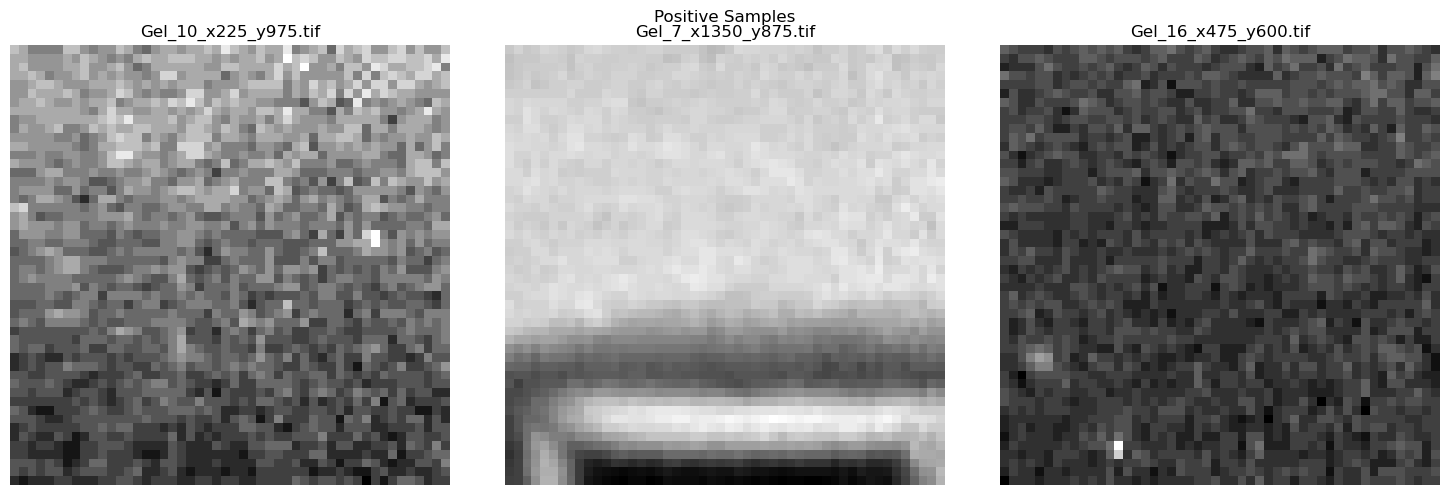

Showing examples from: Background Samples


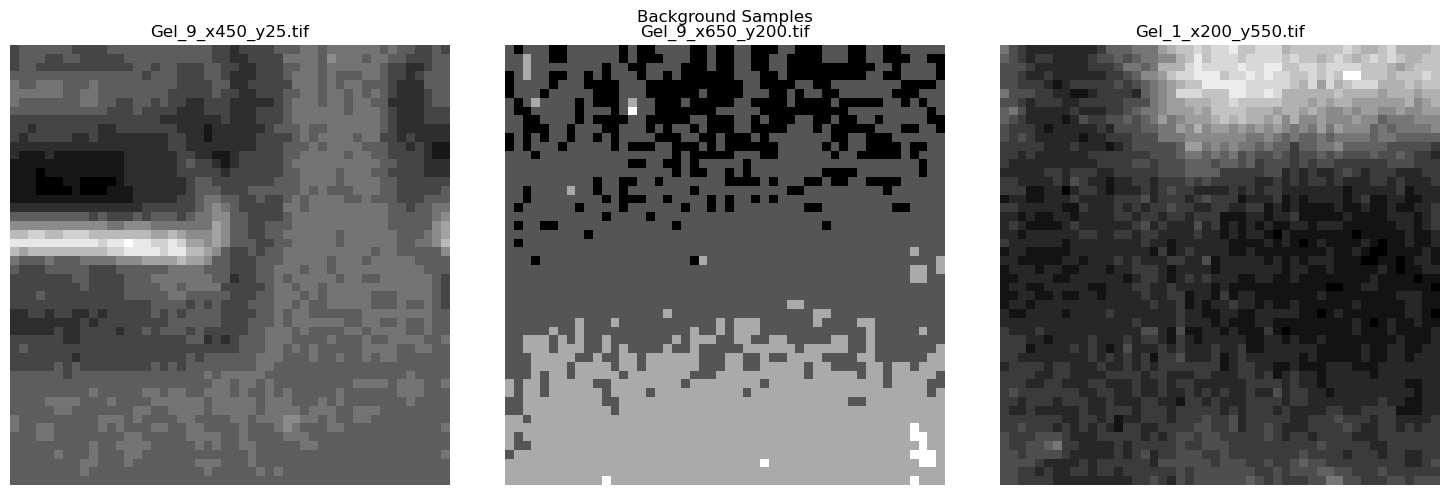

Showing examples from: Augmented Samples (Rotations)


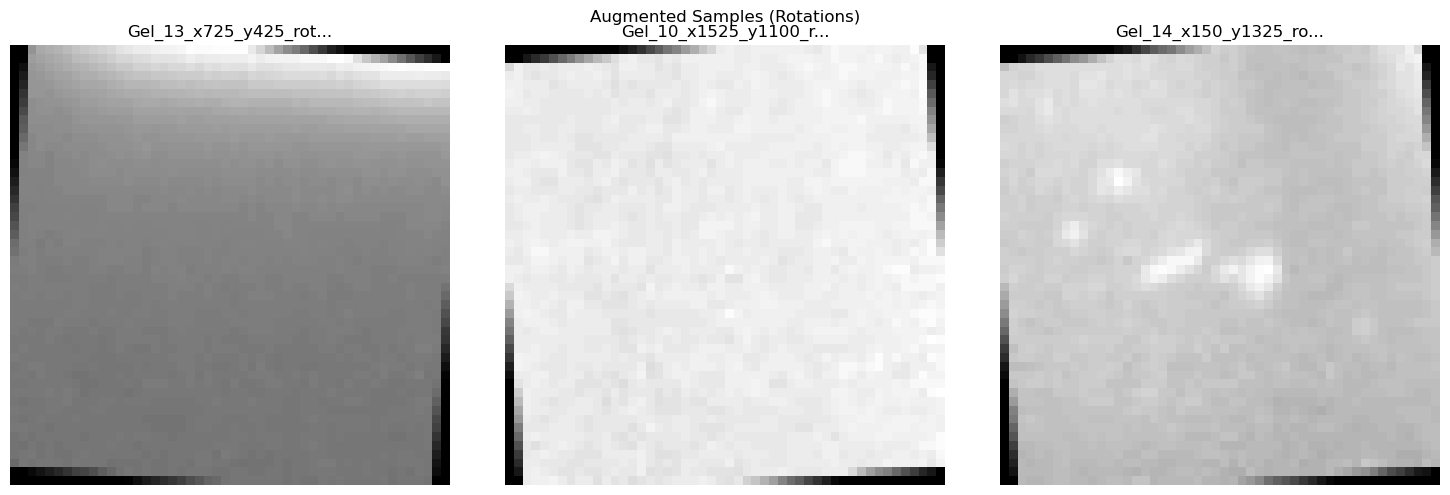

In [47]:
#Check results
print("Band Detection Results:")
band_locations_path = os.path.join(output_dir, "band_locations.csv")
if os.path.exists(band_locations_path) and os.path.getsize(band_locations_path) > 0:
    detected_bands = pd.read_csv(band_locations_path)
    print(detected_bands.head())
    print(f"Total bands detected: {len(detected_bands)}")
else:
    print(f"No valid band locations found at: {band_locations_path}")

pos_dir = os.path.join(training_dir, 'positive')
bg_dir = os.path.join(training_dir, 'background')

if os.path.exists(pos_dir) and os.path.exists(bg_dir):
    positive_samples = len([f for f in os.listdir(pos_dir) if f.endswith('.tif')])
    background_samples = len([f for f in os.listdir(bg_dir) if f.endswith('.tif')])
    print(f"\nTraining Data Summary:")
    print(f"- Positive samples: {positive_samples}")
    print(f"- Background samples: {background_samples}")

aug_dir = os.path.join(augmented_dir, 'training')
if os.path.exists(aug_dir):
    augmented_samples = len([f for f in os.listdir(aug_dir) if f.endswith('.tif')])
    print(f"\nAugmented Data:")
    print(f"- Total augmented samples: {augmented_samples}")

def show_examples(title, directory, count=3):
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return
        
    files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    if not files:
        print(f"No .tif files found in {directory}")
        return
        
    files = files[:count]
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    
    for i, file in enumerate(files):
        plt.subplot(1, count, i+1)
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            plt.imshow(img, cmap='gray')
            plt.title(file[:20] + '...' if len(file) > 20 else file)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nDisplaying example images:")
for dir_name, dir_path in [
    ("Positive Samples", pos_dir),
    ("Background Samples", bg_dir),
    ("Augmented Samples (Rotations)", os.path.join(augmented_dir, 'rotations'))
]:
    if os.path.exists(dir_path) and any(f.endswith('.tif') for f in os.listdir(dir_path)):
        print(f"Showing examples from: {dir_name}")
        show_examples(dir_name, dir_path)
    else:
        print(f"No examples available in: {dir_name}")